## Постановка задачи

<b>Заказчик</b><br>
Компания GoProtect<br>

<b>Описание проекта</b><br>
Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.<br>

<b>Цель</b><br>
Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. 
Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

<b>Pipe-line выполнения проекта</b>
- Загрузка и объединение данных
- Аггрегация отдельных элементов фигурного катания и ошибок
- Создание новых признаков
- Конечная агреггация датасета
- Подготовка к обучению моделей (разделение на тренировочную и тестовую выборки)
- Обучение и тестирование моделей
- Вывод

## Загрузка и объединение данных

Загружаем модули

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.dummy import DummyClassifier

import xgboost as xgb

Определяем константы:
- TRESHOLD - определяет минимальное количество элементов фигурного катания, которое должно быть выполнено в датасете, чтобы был смысл учитывать его в обучении модели
- ACTUAL_PREDICT - определяет столбец, по которому мы будем аггрегировать датасет. Что мы будем предсказывать - выполнение элементов спортсменом за "выступление" или на "турнире" ? (по умолчанию - на всём турнире)
- UNIT_TRESHOLD - минимальное число турниров, на которых должен участвовать спортсмен
- STARK_MARK - считать ли элементы со "звёздочкой" ошибочно выполненными. По условиям задачи эти элементы не засчитываются судьями, но не обязательно из-за ошибки в самом элементе. Значения только 0 и 1

In [2]:
TRESHOLD = 1000
#ACTUAL_PREDICT = 'total_score_id'
ACTUAL_PREDICT = 'tournament_id'
UNIT_TRESHOLD = 3
STAR_MARK = 0

Загружаем данные

In [3]:
total_scores = pd.read_csv('data/total_scores.csv')
tournament_scores = pd.read_csv('data/tournament_scores.csv')
tournaments = pd.read_csv('data/tournaments.csv')
units = pd.read_csv('data/units.csv')

In [4]:
total_scores.shape, tournament_scores.shape, tournaments.shape, units.shape

((21301, 15), (172158, 7), (142, 4), (4596, 3))

Перед тем, как делать полноценный обзор данных, нам нужно объединить датасет.

In [5]:
df = total_scores.copy()
df = df.rename(columns = {'id':'total_score_id'})
df = df.merge(tournament_scores, on = 'total_score_id')#, how = 'left')
tournaments = tournaments.rename(columns = {'id':'tournament_id'})
df = df.merge(tournaments, on = 'tournament_id')
units = units.rename(columns = {'id':'unit_id'})
df = df.merge(units , on = 'unit_id')
df.shape

(172158, 26)

Датасет объединён. Теперь посмотрим на него.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   total_score_id       172158 non-null  int64  
 1   unit_id              172158 non-null  int64  
 2   tournament_id        172158 non-null  int64  
 3   base_score_x         172158 non-null  float64
 4   components_score     172158 non-null  float64
 5   total_score          172158 non-null  float64
 6   elements_score       172158 non-null  float64
 7   decreasings_score    172158 non-null  float64
 8   starting_place       172158 non-null  int64  
 9   place                172158 non-null  int64  
 10  segment_name         172115 non-null  object 
 11  info                 168356 non-null  object 
 12  overall_place        172158 non-null  int64  
 13  overall_total_score  172115 non-null  float64
 14  overall_place_str    85946 non-null   object 
 15  id               

In [7]:
pd.set_option('display.max_columns', None) 
df.head(3)

,total_score_id,unit_id,tournament_id,base_score_x,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,id,title,decrease,base_score_y,goe,avg_score,date_start,date_end,origin_id,color,school_id
0,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,156223,4Lz,NaN,11.5,3.78,15.28,2091-12-20,2091-12-24,2.0,lime,62.0
1,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,156224,4S+3T,NaN,13.9,2.49,16.39,2091-12-20,2091-12-24,2.0,lime,62.0
2,442027,304,4785,47.2,43.47,102.7,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2,156225,FCSp4,NaN,3.2,0.87,4.07,2091-12-20,2091-12-24,2.0,lime,62.0


У нас есть две колонки с датами. Мы видим, что года там проставлены неадекватно, но по условию задачи так и должно быть - года сдвинуты. Переведём дату в дату, а затем создадим числовые признаки 

In [8]:
#Переводим даты в даты
df['date_start'] = pd.to_datetime(df.date_start, format='%Y-%m-%d', errors = 'coerce')
df['date_end'] = pd.to_datetime(df.date_end, format='%Y-%m-%d', errors = 'coerce')
#Смотрим на самую большую дату
df['date_start'].max(), df['date_end'].max()

(Timestamp('2092-04-29 00:00:00'), Timestamp('2092-05-03 00:00:00'))

Теперь создадим признаки - сколько дней прошло с начала и конца турнира. Отсчитывать будем от самой большой даты - то есть от 2092-05-03

In [9]:
#Создаём числовые признаки из дат
df['days_start'] = (pd.to_datetime('2092-05-03', format='%Y-%m-%d') - df['date_start']).dt.days
df['days_end'] = (pd.to_datetime('2092-05-03', format='%Y-%m-%d') - df['date_end']).dt.days
#Признак - сколько длился турнир
df['days'] = df['days_start'] - df['days_end']
#Выведем три первые записи
df[['date_start', 'days_start','days_end','days']].head(3), df[['date_start', 'days_start','days_end','days']].tail(3)

(  date_start  days_start  days_end  days
 0 2091-12-20         135       131     4
 1 2091-12-20         135       131     4
 2 2091-12-20         135       131     4,
        date_start  days_start  days_end  days
 172155 2091-12-06         149       149     0
 172156 2091-12-06         149       149     0
 172157 2091-12-06         149       149     0)

Посмотрим на пропуски

''

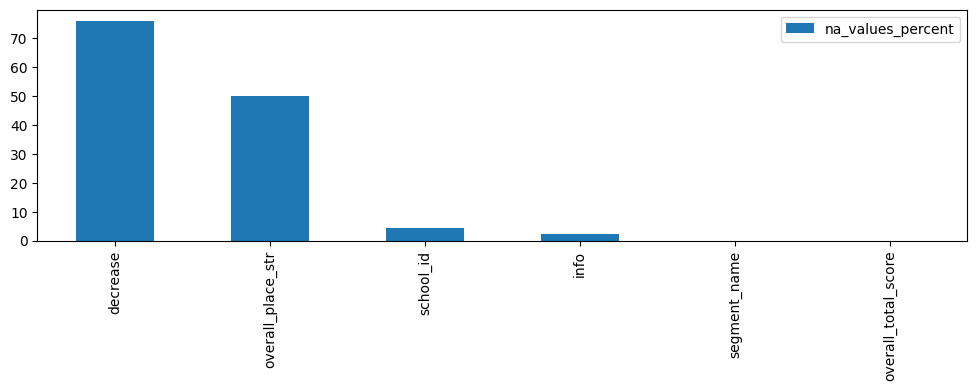

In [10]:
#Вычислим процентное соотношение пропусков 
na_values_percent = ((df.isna().sum() / len(df))*100).to_frame().rename(columns = {0:'na_values_percent'}).sort_values(by = 'na_values_percent', ascending = False)
na_values_percent = na_values_percent.query('na_values_percent > 0').round(2)
#Построим график с процентным соотношением пропусков
na_values_percent.plot.bar(figsize = (12,3))
;

И в числовом виде (числа означают процент пропусков)

In [11]:
na_values_percent.transpose()

,decrease,overall_place_str,school_id,info,segment_name,overall_total_score
na_values_percent,76.08,50.08,4.21,2.21,0.02,0.02


Мы видим, что больше всего пропусков в переменных decrease и overall_place_str. Признак decrease мы сможем использовать, превратив в бинарный признак. Нули будут означать пропуски, единицы - где есть текст.
 При том, мы будем считать под ними те, которые не являются айдишниками. Пока мы исследуем датасет, нам не нужно убирать пропуски, сделаем обработку данных позже. Пока посмотрим на выбросы. Для дальнейшего анализа, нам надо выделить числовые переменные.

In [12]:
num_cols = [] #Список с числовыми колонками
cat_cols = [] #Список с категориальными колонками
id_cols = [] #Список с айдишниками

for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i) #Сюда занисим всё, что является объектом
    else:
        if 'id' in i: 
            id_cols.append(i) #Сюда всё, что является ID
        else:
            num_cols.append(i) #Сюда числовые колонки

cat_cols

['segment_name', 'info', 'overall_place_str', 'title', 'decrease', 'color']

Построим ящики с усами

<Axes: >

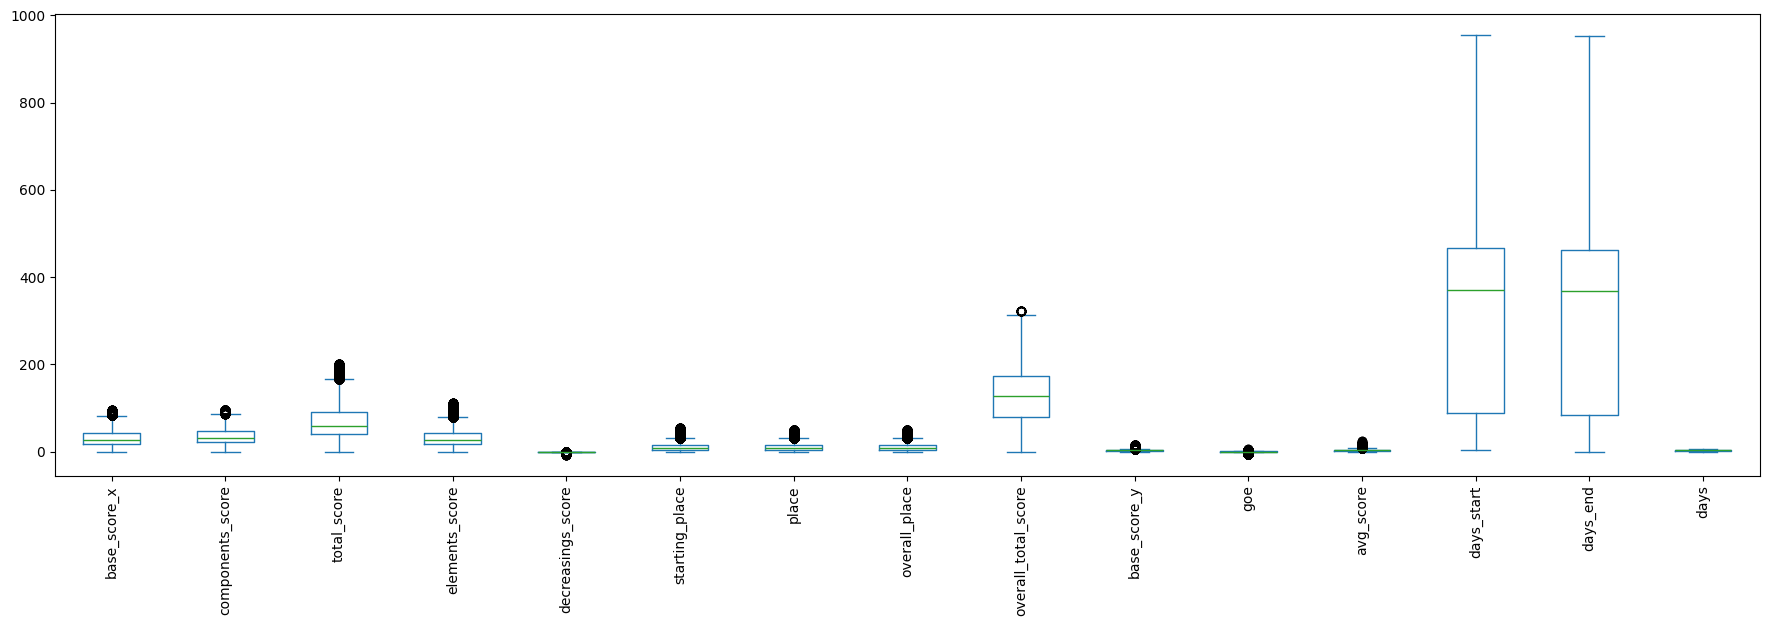

In [13]:
df[num_cols].plot.box(figsize = (22,6), rot = 90)

<Axes: >

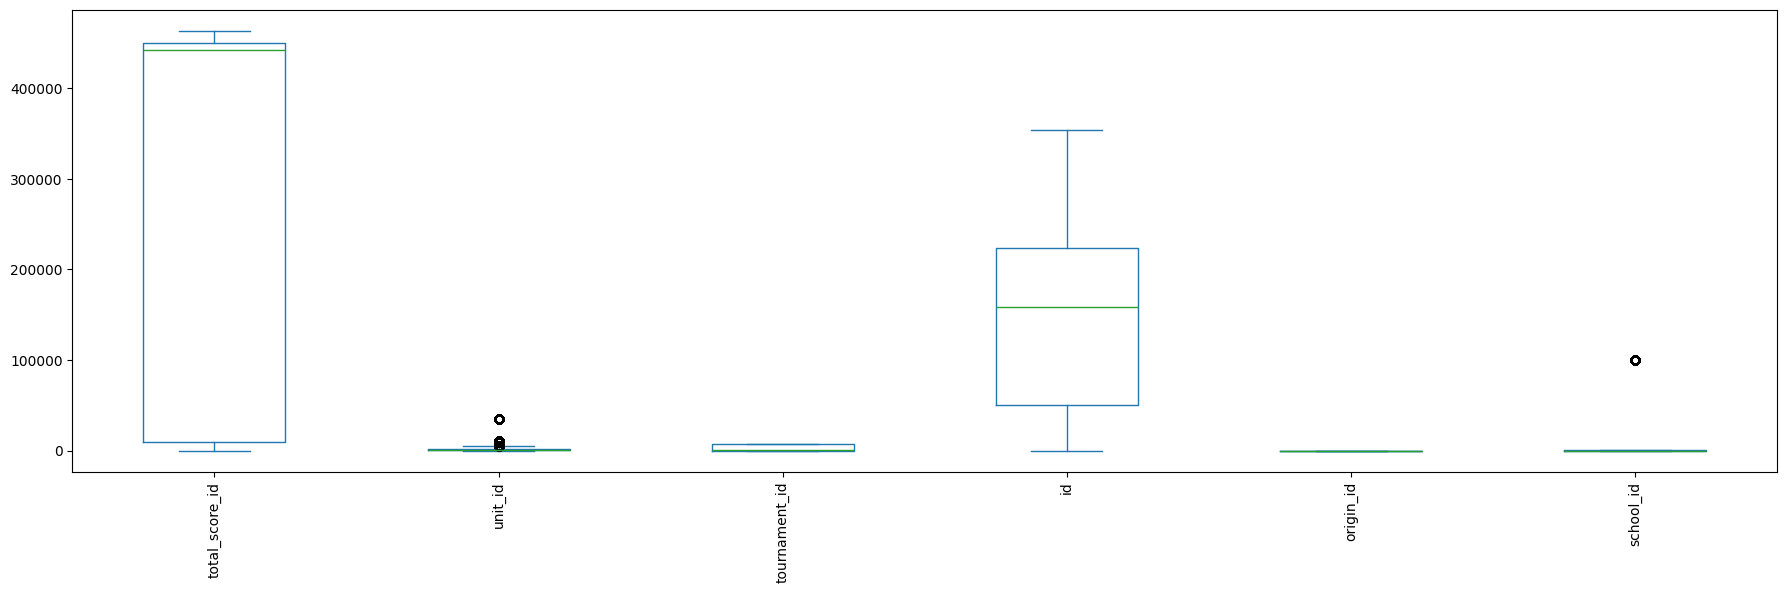

In [14]:
df[id_cols].plot.box(figsize = (22,6), rot = 90)

### Выделение элементов фигурного катания

Согласно техническому заданию, нам нужно выделить элементы фигурного катания. В таблице они даны ввиде строки и имеют примерно следующий вид : 2F!<<+2Lo<<CCoSp2V*
Плюсы означают комбинацию элементов. Также, в элементах множество доролнительных обозначений, которые, чаще всего, обозначают ошибки. Наша задача как раз выявить элементы с ошибками.

In [15]:
len(df.title.unique())

3425

Всего мы наблюдаем 3425 уникальных записей, но многие из них уникальны из-за того, что являются комбинацией. Кстати, длина комбинации может быть полезным признаком

<Axes: xlabel='combo'>

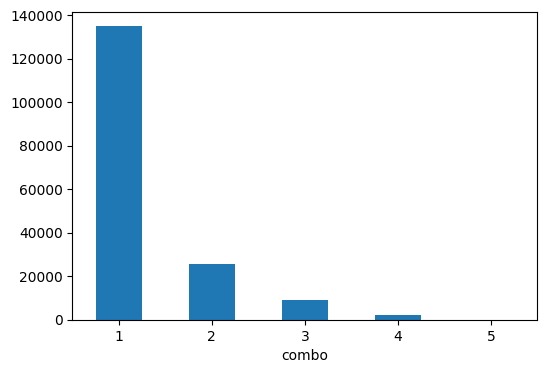

In [16]:
def combo_len(text):
    q = len(text.split('+'))
    return q

df['combo'] = df['title'].apply(combo_len)
df['combo'].value_counts().plot(kind = 'bar', rot = 0, figsize = (6,4))

Мы видим, что чаще всего комбинация состоит из 1 или 2 элементов. Остальное встречается реже (5 - из-за дополнительных меток, фактически не бывает)

In [17]:
df_old = df.copy()

Нам нужно понять, сколько всего уникальных элементов без учёта их сочетаний. 

In [18]:
fints = list(df['title'].unique()) #Переменная со всеми уникальными значениями (даже с учётом комбо)
fints_unique = [] #Переменная для хранения уникальных значений без учёта комбо 

for i in fints: # Проходим по уникальным значениям
    text = i.split('+') # Раделяем комбо по плюсику
    if len(text) == 1: #Если значение только одно, т.е. это не комбо - сразу добавляем его в список
        fints_unique.append(i)
    else: #В противном случае проходимся по получившимуся списку и добавляем каждый элемент
        for i2 in text:
            fints_unique.append(i2)

#Elfkztv le,kbrfns
fints_unique = list(set(fints_unique))
print(f"Первые пять элементов списка : {fints_unique[:5]}") 
print(f"Количество уникальных элементов: {len(fints_unique)}")


Первые пять элементов списка : ['2F!', '2Sq*', '1Fq', 'CSpB', '3T*']
Количество уникальных элементов: 412


У нас есть 412 уникальных элемента. Многие из них получены как раз за счёт ошибок. Нам нужно научиться отделять сам элемент от дополнительной метки ошибки. 

Но для начала нам надо написать вспомогательную функцию. Дело в том, что в датасете есть элементы, которые записаны как бы латинскими буквами, но среди них есть русская, на глаз не различимая с английской (по типу буквы "Е").

In [19]:
# Функция, которая меняет неразличимые русские буквы на их английские аналоги (если они есть в слове)
def wors_to_abc(text):
    new_text = text
    new_text = new_text.replace('а','a')
    new_text = new_text.replace('А','A')
    new_text = new_text.replace('с','c')
    new_text = new_text.replace('С','C')
    new_text = new_text.replace('е','e')
    new_text = new_text.replace('Е','E')
    new_text = new_text.replace('В','B')
    new_text = new_text.replace('Т','T')
    new_text = new_text.replace('о','o')
    new_text = new_text.replace('О','O')
    new_text = new_text.replace('Ssp2','SSp2')
    return new_text

In [20]:
# Функция, которая обработает целый список
def list_to_abc(input_list):
    output_list = []
    for i in input_list:
        output_list.append(wors_to_abc(i))
    return output_list

### Создание списков элементов фигурного катания

Согласно техническому заданию, у нас есть pdf-документ, в котором находятся все исследуемые нами элементы. Однако, нужно учесть некоторую специфику, о которой речь пойдёт ниже. Элементы делятся на прыжки, вращения и шаги.

Сначала рассмотрим прыжки

In [21]:
text_jumps = '''1T Single Toeloop
1S Single Salchow
1Lo Single Loop
1Eu Single Euler (only used in jump combinations)
1F Single Flip
1Lz Single Lutz
1A Single Axel
2T Double Toeloop
2S Double Salchow
2Lo Double Loop
2F Double Flip
2Lz Double Lutz
2A Double Axel
3T Triple Toeloop
3S Triple Salchow
3Lo Triple Loop
3F Triple Flip
3Lz Triple Lutz
3A Triple Axel
4T Quad. Toeloop
4S Quad. Salchow
4Lo Quad. Loop
4F Quad. Flip
4Lz Quad. Lutz
4A Quad. Axel'''

Мы загрузили сырой текст. Приведём его в список самих элементов. 

In [22]:
jumps = [] # Просто возьмём первое слово с каждой строки
for i in text_jumps.split('\n'):
    jumps.append(i.split(' ')[0])


Прыжки имеют цифру в начале, например 3Lz. В техническом задании сказано, что прыжки могут и не иметь цифры в начале, так что дополним список.

In [23]:
all_jumps = [] #Инициализируем дополненный список со всеми прыжками
for i in jumps:
    all_jumps.append(i) #Добавляем оригинальные прыжки
    all_jumps.append(i[1:]) #Добавляем прыжки без цифры

Теперь загрузим вращения

In [24]:
text_spins = '''USp Upright Spin
LSp Layback Spin
CSp Camel Spin
SSp Sit Spin
FUSp Flying Upright Spin
FLSp Flying Layback Spin
FCSp Flying Camel Spin
FSSp Flying Sit Spin
CUSp Change Foot Upright Spin
CLSp Change Foot Layback Spin
CCSp Change Foot Camel Spin
CSSp Change Foot Sit Spin
FCUSp Flying Change Foot Upright Spin
FCLSp Flying Change Foot Layback Spin
FCCSp Flying Change Foot Camel Spin
FCSSp Flying Change Foot Sit Spin
CoSp Combination Spin no change of foot
CCoSp Change Foot Combination Spin
FCoSp Flying Combination Spin no change of foot
FCCoSp Flying Change Foot Comb. Spin
Sp'''

Также приведём текст к списку элементов

In [25]:
spins = []
for i in text_spins.split('\n'):
    spins.append(i.split(' ')[0])
all_spins = []

В техническом задании сказано, что к поворотам может быть приставлена буква B и цифры от 1 до 4. Добавим это в наш список.

In [26]:
for i in spins:
    all_spins.append(i)
    all_spins.append(i + 'B')
    all_spins.append(i + '1')
    all_spins.append(i + '2')
    all_spins.append(i + '3')
    all_spins.append(i + '4') 

Теперь обработаем шаги. Их всего два.

In [27]:

text_steps = '''StSq Step Sequence
ChSq Choreo Sequence'''

Преобразуем в список

In [28]:
steps = []
for i in text_steps.split('\n'):
    steps.append(i.split(' ')[0])

К шагам также могут быть прибавлены цифры и буква B

In [29]:
all_steps = []
for i in steps:
    all_steps.append(i)
    all_steps.append(i + 'B')
    all_steps.append(i + '1')
    all_steps.append(i + '2')
    all_steps.append(i + '3')
    all_steps.append(i + '4') 

Теперь объединим наши списки в общий список элементов

In [30]:
all_fints = all_jumps + all_spins + all_steps +['SEQ']
all_fints = list(set(all_fints))

Обработаем список элементов и список всех уникальных значений из столбца, чтобы убрать русские буквы

In [31]:
all_fints = list_to_abc(all_fints)
fints_unique = list_to_abc(fints_unique)

Посмотрим сколько всего уникальных элементов в датасете, и сколько у нас есть элементов в списке.

In [32]:
print(f"Уникальных элементов в датасете: {len(fints_unique)}")
print(f"Уникальных элементов фигурного катания: {len(all_fints)}")
print(f"Разница: {len(fints_unique) -len(all_fints) }")

Уникальных элементов в датасете: 412
Уникальных элементов фигурного катания: 171
Разница: 241


Мы видим, что в датасете на 230 элементов больше. Это связано с пометками об ошибках, как раз то, что нам нужно. Нам нужно убедиться, что мы действительно получили все необходимые элементы, а также, найти все виды пометок об ошибках исполнения. 

### Проверка элементов
Мы получили список элементов (которые нам дан в ТЗ). Нужно рассортировать его по длине строки, причём, в порядке убывания.

In [33]:
all_fints.sort(key=lambda s: len(s)) #Сортируем список по длине строки
all_fints.reverse()#Переворачиваем список, чтобы сначала шли длинные

В нашем датасете теоретически могут быть три типа элементов:
- 1.Полностью совпадающие с нашими элементами
- 2.Частично совпадающие с нашими элементами, то есть в конце будет ещё какая-то метка
- 3.Полностью несовпадающие с нашими элементами

Следуя нашей гипотезе, элементы второго типа - это ошибки. Чтобы проверить это мы получим их "хвосты" и посмотрим на них.

Третьи - это возможные неучтённые элементы и нам нужно проверить их наличие.



In [34]:
tails_and_unknown = [] #Инициализируем список "хвостом" и неизвестных элементов
tails = [] #Инициализиоруем список только "хвостов"

#Проходим по всему списку уникальных в датасете
for i in fints_unique:
    text = i 
    for i2 in all_fints: #Проходимся по списку наших элементов (которые из ТЗ)
        finded = i.find(i2)
        #Ищем вхождение подстроки, состоящей из нашего элемента в уникальный элемент
        #Дальнейшие действия проводим, только если подстрока входит с начала
        if finded == 0:
            #Удаляем подстроку, состоящую из нашего элемента
            text = text.replace(i2, '')
            #Если строка не пустая, это значит, что в остался "хвост". В случае незнакомого элемента действие вообще выполнено не будет (так как finded будет равна -1)
            if len(text) > 0:
                tails.append(text)
                
    tails_and_unknown.append(text) #Сюда пойдут обработанные элементы (то есть, "хвосты" и пустые строки), а также неизвестные элементы


#Убираем дубликаты из наших списков
tails_and_unknown = list(set(tails_and_unknown))
tails = list(set(tails))


Мы получили списки "хвостов" и неизвестных элементов. Посмотрим на неизвестные элементы

In [35]:
unknown_elements = set(tails_and_unknown) - set(tails)
unknown_elements

{'', '1W', 'COMBO', 'COMBO*', 'ChSpl', 'ChSpl1', 'REP'}

COMBO, COMBO* и REP - ошибки сами по себе, являющиеся элементом. Потому они и не попали в список наших элементов. Посмотрим сколько остальных.

In [36]:
for i in list(unknown_elements)[1:]:
    print(f"Название неизвестного элемента: {i}, встречается в датасете {len(df[df['title'].str.contains(i, regex = False)])} раза")



Название неизвестного элемента: ChSpl1, встречается в датасете 1588 раза
Название неизвестного элемента: REP, встречается в датасете 896 раза
Название неизвестного элемента: 1W, встречается в датасете 3 раза
Название неизвестного элемента: COMBO*, встречается в датасете 29 раза
Название неизвестного элемента: ChSpl, встречается в датасете 1717 раза
Название неизвестного элемента: COMBO, встречается в датасете 1287 раза


1W - элемент, который встречается всего три раза. Очевидно, этого недостаточно для обучения модели. В будущим мы удалим эти записи. ChSpl и ChSpl1 - хореографические элементы. 

Добавим в список новые элементы

In [37]:
all_fints += ['COMBO', 'REP', 'ChSpl','ChSpl1', '1W']

Заново отсортируем список всех элементов

In [38]:
all_fints.sort(key=lambda s: len(s)) #Сортируем список по длине строки
all_fints.reverse()#Переворачиваем список, чтобы сначала шли длинные



Посмотрим на оставшиеся хвосты

In [39]:
#Напечатаем список так, чтобы он поместился в строку, а не в столбик
for i in tails:
    print(i, end = ', ')

e*, <<, V, V*, q, !q, e, <, e<<, e<*, eq, <*, !<, q*, <<*, !<*, !q*, e<, !, !*, *, !<<, !<<*, *<, 

Это действительно похоже на ошибки, о которых сказано в ТЗ. Ssp2 - очевидно опечатка и имелось в виду SSp2 

### Вывод

Мы загрузили и объединили датасет, а также исследовали элементы фигурного катания, которые записаны в колонке "title". Мы смогли составить правильный список элементов фигурного катания и убедились, что в датасете представлены именно они . Также мы определили набор ошибок, с которым нам предстоит работать. Теперь наша задача преобразовать сам датасет.

## Подготовка данных

Для начала нам нужно просто разделить элементы

In [40]:
#Превращаем все комбинации в отдельные строки
df= df.assign(title=df.title.str.split("+")).explode('title') 
print(f"После разделения датасет стал длиннее на {len(df) - len(df_old)} строк")

После разделения датасет стал длиннее на 51011 строк


Теперь нам нужно отделить сами элементы и их "хвосты". Напишем вспомогательную функцию. Она будет возвращать название элемента (без "хвоста"), маркер наличия ошибки и саму ошибку. Также запишем дополнительные признаки - были ли метки *, COMBO и так далее.

In [41]:
def set_elemet_and_mark(text):
    mark = 1
    star = 0
    err = 'NOT'
    is_combo = 0
    seq = 0
    rep = 0
    text_element = 'err'
    text = wors_to_abc(text) # конвертируем текст
    for i in all_fints: # Перебираем все элементы
        finded = text.find(i)
        if finded == 0:
            text_element = i
            err = text.replace(i,'') # Заполняем столбец с ошибкой
            if err == '':
                err = 'NOT' # Помечаем, что ошибки нет
            if err == '*':
                mark = STAR_MARK
                star = 1
            if len(text.replace(i,'')) == 0: # Если ошибки нет, то ставим метку что ошибки нет
                mark = 0
            # Заполняем дополнительные признаки
            if text_element == 'COMBO':
                is_combo = 1
            if text_element == 'REP':
                rep = 1
            if text_element == 'SEQ':
                seq = 1

            break

    return text_element, mark, err, star, is_combo, rep, seq

Применим функцию к датасету

In [42]:
tqdm.pandas() #Для отображения полоски прогресса

In [43]:
#Применяем функцию, создавая два новых столбца
def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].progress_apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

In [44]:
df = apply_and_concat(df, 'title', set_elemet_and_mark, ['element', 'mark', 'err', 'star', 'is_combo', 'rep', 'seq'])
;

  0%|          | 0/223169 [00:00<?, ?it/s]

''

Посмотрим, что у нас получилось

In [45]:
df.query('mark == 1')[['title', 'element', 'mark', 'err']].head(5), df.query('mark == 0')[['title', 'element', 'mark', 'err']].head(5)

(       title element  mark err
 51      3T<<      3T     1  <<
 69      3Lzq     3Lz     1   q
 86       3F!      3F     1   !
 141      3F!      3F     1   !
 144  CCoSp4V  CCoSp4     1   V,
    title element  mark  err
 0    4Lz     4Lz     0  NOT
 1     4S      4S     0  NOT
 1     3T      3T     0  NOT
 2  FCSp4   FCSp4     0  NOT
 3     3A      3A     0  NOT)

Функция верно отделила ошибки от элементов. Но чтобы проверить её адекватность, нужено глянуть на те ошибки которые она нашла и сверить с нашим списком

In [46]:
for i in list(set(tails)):
    print(i, end = ', ')
print('\n')
for i in list(set(list(df['err'].unique()))):
    print(i, end = ', ')

e*, <<, V, V*, q, !q, e, <, e<<, e<*, eq, <*, !<, q*, <<*, !<*, !q*, e<, !, !*, *, !<<, !<<*, *<, 

e*, <<, V, V*, q, !q, NOT, e, <, e<<, e<*, eq, <*, !<, <<*, q*, !<*, e<, !q*, !, !*, *, !<<, !<<*, *<, 

Как видим списки совпадают. Появился только элемент NOT, обозначающий отсутствие ошибки. Посмотрим на элементы

In [47]:
len(df['element'].unique()), len(all_fints)

(117, 176)

Мы видим, что в датасете меньше элементов, чем в нашем списке. Некоторые элементы действительно не входят в наш датасет.

In [48]:
zero_elements = []
for i in list(all_fints)[1:]:
    if len(df_old[df_old['title'].str.contains(i, regex = False)]) == 0:
        zero_elements.append(i)

for i in zero_elements:
    print(i, end = ', ')

FCCSp3, FCLSpB, FCCSp1, FCUSp3, FCUSpB, FCLSp3, FCoSp4, FCCSpB, FCLSp1, FCCSp2, FCLSp2, FCUSp2, FCUSp4, FCoSp1, FCLSp4, FCoSp3, FCUSp1, FCoSpB, CUSp4, FCLSp, FLSp1, FLSpB, FUSp4, CLSp3, CLSp1, ChSqB, CLSpB, FUSp2, CLSp4, CLSp2, CUSp1, CUSp3, ChSq4, CUSpB, FCUSp, FUSp3, FUSpB, CUSp2, ChSq2, ChSq3, USp3, CLSp, CUSp, USp4, USp2, 4A, 

Надо проверить, нет ли незнакомых элементов в датасете

In [49]:
actual_fints = list(df['element'].unique())
for i in actual_fints:
    new_fint = 1
    for i2 in all_fints:
        if i == i2:
            new_fint = 0
            print('.', end='')
    if new_fint == 1:
        print(i)

.....................................................................................................................

Как видим, всё прошло корректно. Посмотрим, сколько вообще есть тех или иных элементов в датасете.

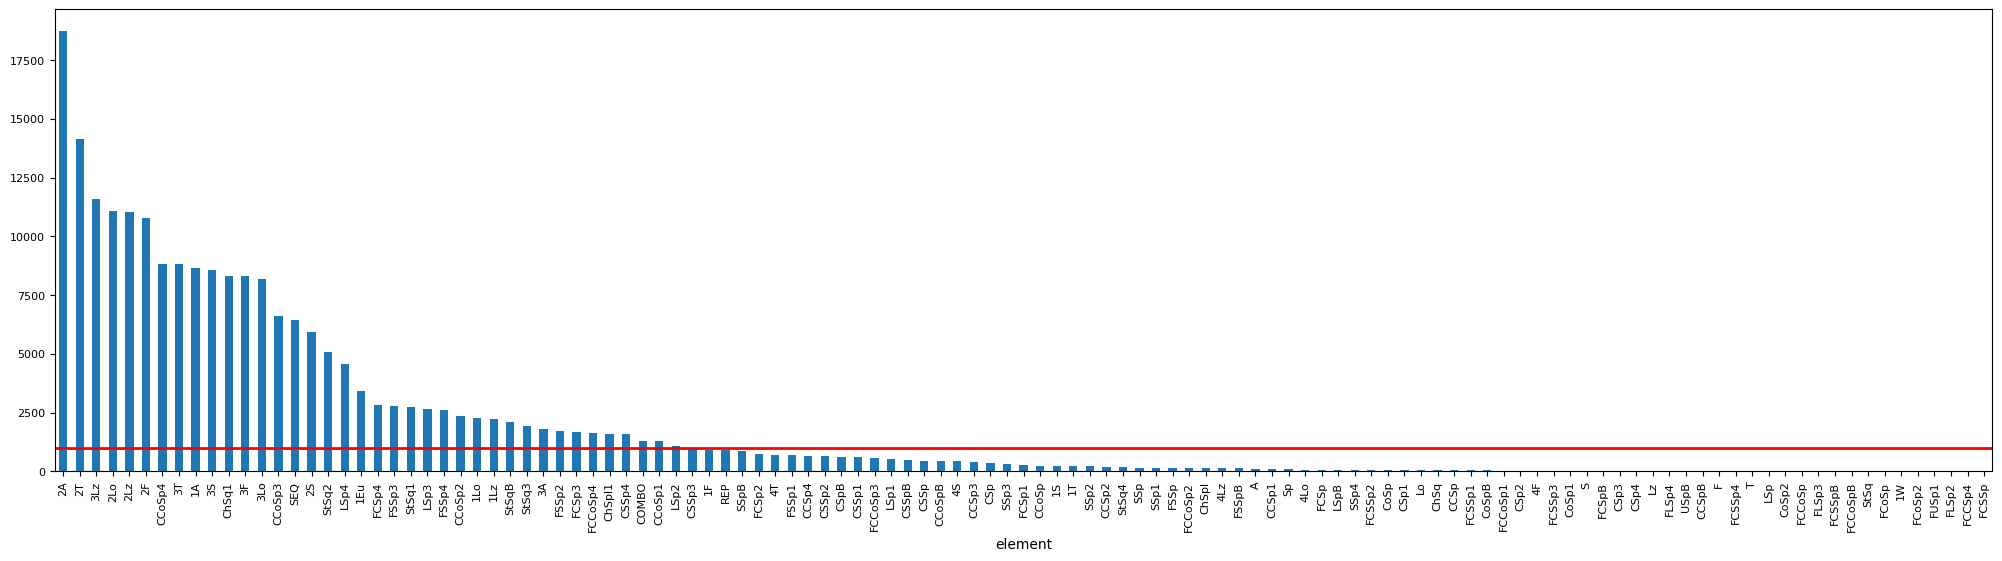

In [50]:
elements_count = df.element.value_counts()
elements_count.plot.bar(figsize = (25,6), fontsize = 8).axhline(y=TRESHOLD, color= 'red', linewidth=2,)

Как мы видим, большое количество элементов во всём датасете встречалось меньше 1000 раз. Для модели это мало. Помимо этого, в рамках ТЗ нам нужно предсказать правильность выполнения самих] элементов (прыжки, вращения и шаги).
Спортсмен может допускать ошибки другого вида - неправильно выполнять комбинации, падать, делать лишние прыжки в комбинации когда этого не надо, делать прыжки, которые не входят в программу и так далее. Однако, это выходит за рамки нашей задачи, потому мы также не будем учитывать такие ошибки. Наша задача лишь предсказать качество выполнения элементов самих по себе.


### Вывод
Мы успешно выделили элементы и отделили их от меток погрешностей. Теперь нам нужно собрать датасет, на котором будем обучать модель.

### Создание искусственных признаков и агреггация данных

Признак "decrease" пояснение за что снижена оценка. Хотя мы не будем обрабатывать текст замечаний, само их наличие - полезный признак.

In [51]:
df['decrease'] = df['decrease'].progress_apply(lambda x: 0 if x != x else 1)

  0%|          | 0/223169 [00:00<?, ?it/s]

Признак segment_name означает название сегмента, в котором выступает спортсмен. Так как их немного, просто переведём в номера. Но для начала посмотрим на этот признак

In [52]:
df['segment_name'].unique(), len(df['segment_name'].unique())

(array(['Короткая программа', 'Произвольная программа',
        'Произвольнaя программа', 'Кoроткая программа',
        'Прoизвольная прoграмма', 'Прыжки', 'Элементы',
        'Произвольная программа.', 'Элeмeнты', 'Kopoткaя пpoгpaммa',
        'Пpoизвoльнaя пpoгpaммa', 'Кopoткaя пpoгpaммa',
        'Коpоткая программа', 'Пpoизвольная программа',
        'Пpoизвольнaя программа', 'Интерпретация', 'Интерпретация.', nan],
       dtype=object),
 18)

Мы видим, что некоторые значения повторяются. Исправим это

In [53]:
df['segment_name'] = df['segment_name'].fillna('Другое') #Заполним пропуски в этой колонке

Теперь переделаем дублирующие имена

In [54]:
def segment_name_unification(text):
    if text in ['Короткая программа', 'Кoроткая программа', 'Kopoткaя пpoгpaммa', 'Кopoткaя пpoгpaммa', 'Коpоткая программа']:
        return 'Короткая программа'
    if text in ['Произвольная программа', 'Произвольнaя программа', 'Прoизвольная прoграмма', 'Произвольная программа.', 'Пpoизвoльнaя пpoгpaммa', 'Пpoизвольная программа','Пpoизвольнaя программа' ]:
        return 'Произвольная программа'
    if text in ['Элементы', 'Элeмeнты']:
        return 'Элементы'
    if text in ['Интерпретация', 'Интерпретация.']:
        return 'Интерпретация'
    return text

Применем функцию к данным

In [55]:
df['segment_name'] = df['segment_name'].progress_apply(segment_name_unification)

  0%|          | 0/223169 [00:00<?, ?it/s]

Посмотрим на количество данных

In [56]:
df['segment_name'].value_counts()

segment_name
Произвольная программа    152896
Короткая программа         63663
Элементы                    5186
Прыжки                      1216
Интерпретация                165
Другое                        43
Name: count, dtype: int64

Мы видим, что прыжков и интерпретаций очень мало. Назовём их "Другое".

In [57]:
df['segment_name'] = df['segment_name'].progress_apply(lambda x: 'Другое' if x in ['Прыжки', 'Интерпретация'] else x)

  0%|          | 0/223169 [00:00<?, ?it/s]

Признак очищен успешно

In [58]:
df['segment_name'].value_counts()

segment_name
Произвольная программа    152896
Короткая программа         63663
Элементы                    5186
Другое                      1424
Name: count, dtype: int64

Теперь нам нужно превратить это в числа

In [59]:
segment_names = list(df['segment_name'].unique())
df['segment_name'] = df['segment_name'].progress_apply(lambda x: segment_names.index (x) if x in segment_names else -1)

  0%|          | 0/223169 [00:00<?, ?it/s]

Разберёмся с признаком color, также превратив его в числа

In [60]:
colors = list(df['color'].unique())
df['color'] = df['color'].progress_apply(lambda x: colors.index (x) if x in colors else -1)

  0%|          | 0/223169 [00:00<?, ?it/s]

In [61]:
df['color'].value_counts()

color
1    160235
0     62934
Name: count, dtype: int64

Мы успешно превратили признак в числа. Как видим, у нас всего два числа, так что с этим признаком проблем нет. Цвета в данном случае обозначают пол спортсмена, но мы не знаем какой цвет какой пол обозначает, да и в рамках решения задачи это не важно.

Так же нам надо инвертировать признаки days_start и days_end, так как они показывают, сколько времени назад закончился турнир. 

In [62]:
df['days_start'] = df['days_start']*(-1)
df['days_end'] = df['days_end']*(-1)



### Агрегация данных
Теперб нам нужно собрать сам датасет, на котором мы уже сможем обучить и протестировать нашу модель

Для начала создадим вспомогательный датасет. В будущем мы удалим такие элементы как COMBO, SEQ и так далее, так как в рамках задачи, они нам не интересны. Потому извлечём из них признаки заранее. 

In [63]:
#ACTUAL_PREDICT - константа, в которой находится название поля, по которому мы будем в итоге агреггировать строки. В данном случае это tournament_id. Таким образом, мы группируем данные по спортсмену и турниру

df_00 = df.groupby(by = ['unit_id', ACTUAL_PREDICT]).agg(  
    is_combo_sum = ('is_combo','sum'), #Сумма пометок COMBO
    rep_sum = ('rep', 'sum'), #Сумма пометок REP
    seq_sum = ('seq', 'sum'), # Сумма пометок SEQ
    star_sum = ('star', 'sum'),# Сумма элементов со звёздочкой
    total_count = ('is_combo', len), #Общее количество элементов, выполнеенных жанным спортсменом за турнир
    base_score_y_mean = ('base_score_y', 'mean'), #Среднняя base_score_y
    decrease_mean = ('decrease', 'mean'), #Среднее количество пометок об ошибке
    decrease_sum = ('decrease', 'sum'), #Абсолютное количество пометок об ошибке (записей)
    combo_sum= ('combo', 'sum'), #Общая сумма каскадов и комбо (элементов типа 2F + SpB)
    combo_mean= ('combo', 'mean'),  #Среднее количество каскадов и комбо (элементов типа 2F + SpB)
    goe_mean = ('goe', 'mean'), #Среднее goe
    errors_sum = ('mark','sum'), #Количество ошибок
    erorres_mean = ('mark', 'mean') #Среднее количество ошибко

    
    ).reset_index()

In [64]:
df_00.head(2)

,unit_id,tournament_id,is_combo_sum,rep_sum,seq_sum,star_sum,total_count,base_score_y_mean,decrease_mean,decrease_sum,combo_sum,combo_mean,goe_mean,errors_sum,erorres_mean
0,1,1,0,0,0,0,23,4.150435,0.304348,7,35,1.521739,-0.114783,4,0.173913
1,1,3,0,0,0,0,8,3.387500,0.125000,1,10,1.250000,0.356250,1,0.125000


Мы успешно создали промежуточную таблицу, теперь надо её объединить с нашими данными. 

In [65]:
df2 = df.merge(df_00, on = ['unit_id', ACTUAL_PREDICT]) #Объединим данные

In [66]:
df2 = df2.drop(columns = ['star', 'is_combo', 'rep', 'seq', 'decrease','goe', 'base_score_y', 'combo']) # Удалим лишние стобцы


Теперь нам нужно упорядочить турниры, в которых участвовал спортсмен. Упорядочивать их будем от самого раннего к более позднему, то есть сначала пойдут самые старые турниры. 

In [67]:
df3 = df2.groupby(by = ['unit_id','days_start',ACTUAL_PREDICT] )['decrease_mean'].mean().reset_index() #Группируем по decrease_mean так как нам надо по чему-то группировать

Теперь создадим колонку number в которой будет записан порядковый номер турнира, в котором участвовал данный спортсмен

In [68]:
df3['number'] = 0 # Инициализируем новый столбец
unit_id_now = 1 # Переменная для запоминания id конкретного спортсмена
counter = 0 # Наш счётлчик
for i in tqdm(range(len(df3))): # Проходим по всему датасету
    unit_id_new = df3.at[i,'unit_id'] # Инициализируем переменную, которая позволит нам понять, это всё тот же спортсмен или уже другой
    if unit_id_new != unit_id_now: # Если мы дошли до нового спортсмена - обнуляем счётчик и запоминаем id нового спортсмена
        unit_id_now = unit_id_new
        counter = 0
    df3.at[i,'number'] = counter # Присваиваем новому столбцу значение счётчика
    counter += 1
    
    

  0%|          | 0/12555 [00:00<?, ?it/s]

In [69]:
df3.head()

,unit_id,days_start,tournament_id,decrease_mean,number
0,1,-745,84,0.166667,0
1,1,-576,3,0.125000,1
2,1,-521,1,0.304348,2
3,1,-469,21,0.250000,3
4,1,-437,33,0.416667,4


Мы успешно пронумеравали данные.

In [70]:
df3 = df3.drop(columns = 'decrease_mean') # Удалим лишний столбец

In [71]:
df2 = df2.merge(df3, on = ['unit_id', 'days_start',ACTUAL_PREDICT]) # Объединим с нашими данными

Добавим также значение максимального номера. Оно будет обозначать количество турниров, в которых спортсмен вообще участвовал (общее количество турниров на единицу больше, так как счёт начинается с нуля) 

In [72]:
df3 = df2.groupby(by='unit_id').agg(max_number = ('number', 'max')).reset_index()
df2 = df2.merge(df3, on = ['unit_id']) #Объединим данные


Теперь получим наш датасет и отфильтруем его. Мы будем удалять всех спортсменов, которые участвовали меньше чем в UNIT_TRESHOLD турнирах (в данном случае, минимум - три спортсмена). Также удалим элементы, которые являются метками - типа COMBO и т.п.

In [73]:
drop_list = ['COMBO', 'SEQ', 'REP'] #Список элементов на удаление
df = df2.copy() 
df = df.query('element not in @drop_list and max_number >= (@UNIT_TRESHOLD - 1)') # Фильтруем датасет. В него будут попадать только те записи, где спортсмен участовал хотя бы в UNIT_TRESHOLD турнирах

Выше мы видели, что многие элементы выполнялись малое количество раз за всё время. Выделим эти элементы и запишем их в отдельный список 

In [74]:
elements_count = df.element.value_counts() # Количество выполнений каждого элемента
other_elemenst_sum = elements_count.reset_index(drop=False).query('count <= @TRESHOLD')['count'].sum() # Посмотрим на общее количество выполнений "других" элементов
elements_count = elements_count.reset_index(drop=False).query('count >= @TRESHOLD') # Запомним ите элементы, которые были выполнены больше пороговорого значения
other_elemenst_sum

13185

In [75]:
elements_count = list(elements_count['element']) # Преобразуем в список

Теперь присвоим всем "редким" элементам значение "другое". И посмотрим на то, что у нас получилось

  0%|          | 0/178621 [00:00<?, ?it/s]

<Axes: xlabel='element'>

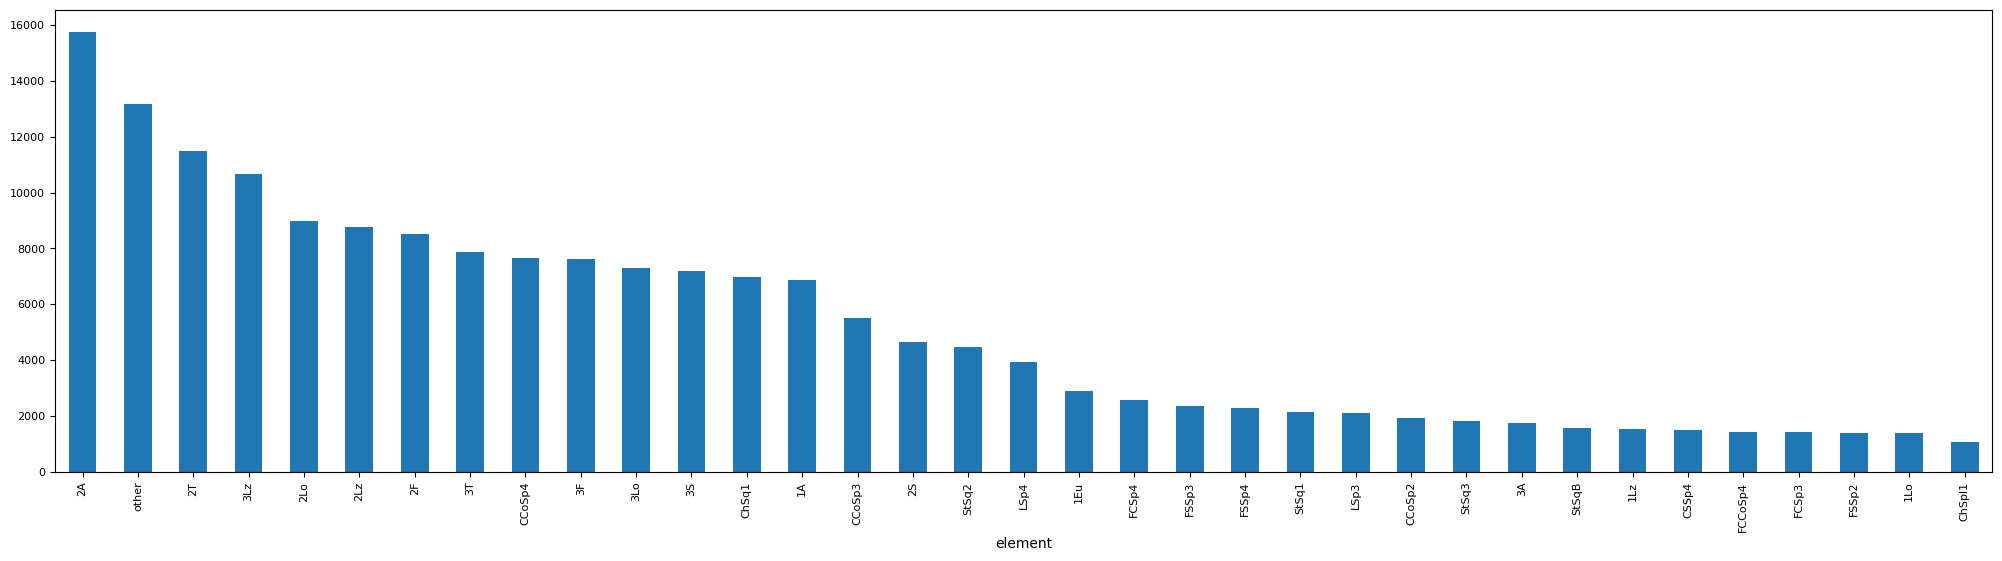

In [76]:

df['element'] = df['element'].progress_apply(lambda x: x if x in elements_count else 'other')
elements_count = df.element.value_counts()
elements_count.plot.bar(figsize = (25,6), fontsize = 8)

Мы видим, что элементов стало гораздо меньше. При том, общая сумма "других" элементов существенна.


In [77]:
df = df.drop(columns = ['info', 'overall_place_str', 'avg_score', 'date_start', 'date_end']) # Убираем лишние колонки

In [78]:
elements = list(df['element'].unique() )

Пока наши элементы и ошибки имеют вид категориальных признаков со множеством категорий. Мы хотим предсказать, какие элементы сможет выполнить спортсмен за весь турнир, или в каких элементах он ошибётся или какие элементы спортсмен попытается выполнить вне зависимости от финального результата.

Для начала создадим новые столбцы, в которых будут записаны элементы.

In [79]:
errors = list(df['err'].unique())
df['err'] = df['err'].progress_apply(lambda x: errors.index (x) if x in errors else -1)

  0%|          | 0/178621 [00:00<?, ?it/s]

In [80]:
err_elements = []
correct_elements = []
completed_elements = []
df['err_elements'] = df.apply(lambda row:  row["element"] if row["mark"] == 1 else 'NOT', axis=1) # Столбец с элементами, выполненными с ошибками (хотя бы одна ошибка за турнир)
df['correct_elements'] = df.apply(lambda row: row["element"] if row["mark"] == 0 else 'NOT', axis=1) # Столбец с элментами, выполненными верно (хотя бы один раз за турнир)
df['completed_elements'] = df['element'] # Столбец с элементами, которые спортсмен попытался выполнить вне зависимости от результата
df['type_error'] = df['err'] # Столбец с конкретными ошибками (полезен как дополнительный обучающий пизнак)
df['type_segment'] = df['segment_name'] # Столбец с номером сегмента

In [81]:
df = df.drop(columns = ['element', 'mark','err', 'title', 'segment_name']) # Убираем лишние столбцы

Теперь переведём наши данные в бинарные признаки, то есть, каждый элемент (и т.п.) будет соответствующим признаком.

In [82]:
df = pd.get_dummies(df, columns = ['correct_elements', 'err_elements', 'completed_elements', 'type_error', 'type_segment'], drop_first= False, dtype=int)


Заполним оставшиеся пропуски

In [83]:
df = df.fillna(-1)

Создаём финальный датасет

In [84]:
df = df.groupby(by = ['unit_id','days_start',ACTUAL_PREDICT] ).max().reset_index()

Удаляем лишние столбцы

In [85]:
for i in df.columns:
    if '_NOT' in i:
        df = df.drop(columns = i)

Нам удалось собрать финальный датасет

In [86]:
df.head()

,unit_id,days_start,tournament_id,total_score_id,base_score_x,components_score,total_score,elements_score,decreasings_score,starting_place,place,overall_place,overall_total_score,id,origin_id,color,school_id,days_end,days,is_combo_sum,rep_sum,seq_sum,star_sum,total_count,base_score_y_mean,decrease_mean,decrease_sum,combo_sum,combo_mean,goe_mean,errors_sum,erorres_mean,number,max_number,correct_elements_1A,correct_elements_1Eu,correct_elements_1Lo,correct_elements_1Lz,correct_elements_2A,correct_elements_2F,correct_elements_2Lo,correct_elements_2Lz,correct_elements_2S,correct_elements_2T,correct_elements_3A,correct_elements_3F,correct_elements_3Lo,correct_elements_3Lz,correct_elements_3S,correct_elements_3T,correct_elements_CCoSp2,correct_elements_CCoSp3,correct_elements_CCoSp4,correct_elements_CSSp4,correct_elements_ChSpl1,correct_elements_ChSq1,correct_elements_FCCoSp4,correct_elements_FCSp3,correct_elements_FCSp4,correct_elements_FSSp2,correct_elements_FSSp3,correct_elements_FSSp4,correct_elements_LSp3,correct_elements_LSp4,correct_elements_StSq1,correct_elements_StSq2,correct_elements_StSq3,correct_elements_StSqB,correct_elements_other,err_elements_1A,err_elements_1Eu,err_elements_1Lo,err_elements_1Lz,err_elements_2A,err_elements_2F,err_elements_2Lo,err_elements_2Lz,err_elements_2S,err_elements_2T,err_elements_3A,err_elements_3F,err_elements_3Lo,err_elements_3Lz,err_elements_3S,err_elements_3T,err_elements_CCoSp2,err_elements_CCoSp3,err_elements_CCoSp4,err_elements_CSSp4,err_elements_FCCoSp4,err_elements_FSSp2,err_elements_FSSp3,err_elements_FSSp4,err_elements_other,completed_elements_1A,completed_elements_1Eu,completed_elements_1Lo,completed_elements_1Lz,completed_elements_2A,completed_elements_2F,completed_elements_2Lo,completed_elements_2Lz,completed_elements_2S,completed_elements_2T,completed_elements_3A,completed_elements_3F,completed_elements_3Lo,completed_elements_3Lz,completed_elements_3S,completed_elements_3T,completed_elements_CCoSp2,completed_elements_CCoSp3,completed_elements_CCoSp4,completed_elements_CSSp4,completed_elements_ChSpl1,completed_elements_ChSq1,completed_elements_FCCoSp4,completed_elements_FCSp3,completed_elements_FCSp4,completed_elements_FSSp2,completed_elements_FSSp3,completed_elements_FSSp4,completed_elements_LSp3,completed_elements_LSp4,completed_elements_StSq1,completed_elements_StSq2,completed_elements_StSq3,completed_elements_StSqB,completed_elements_other,type_error_0,type_error_1,type_error_2,type_error_3,type_error_4,type_error_5,type_error_6,type_error_7,type_error_8,type_error_9,type_error_10,type_error_11,type_error_12,type_error_13,type_error_14,type_error_15,type_error_16,type_error_17,type_error_18,type_error_19,type_error_20,type_error_21,type_error_22,type_error_23,type_error_24,type_segment_0,type_segment_1,type_segment_2,type_segment_3
0,1,-745,84,14419,56.73,50.08,110.84,60.76,0.0,16,13,8,160.10,81674,1.0,1,198.0,-742,3,0,0,0,0,24,4.995833,0.166667,4,36,1.500000,-0.065000,2,0.083333,0,14,0,1,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,1,-576,3,3865,20.76,24.74,47.61,22.87,0.0,6,27,28,47.61,5171,2.0,1,198.0,-573,3,0,0,0,0,8,3.387500,0.125000,1,10,1.250000,0.356250,1,0.125000,1,14,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,-521,1,8,57.30,49.40,107.58,58.18,0.0,2,5,4,164.44,18,2.0,1,198.0,-519,2,0,0,0,0,23,4.150435,0.304348,7,35,1.521739,-0.114783,4,0.173913,2,14,0,1,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0

### Вывод

Мы собрали финальный датасет и создали обучающие признаки

## Обучение и тестирование моделей

### Подготовка данных

Теперь нам надо разделить данные на обучающую и тестовую выборки. При том, мы укажем какие данные мы будем использовать для обучения и какие данные мы будем предсказывать. Например, будем ли мы предсказывать ошибочно выполненные элементы или наоборот?

В качестве признаков мы будем использовать данные из прошлых турниров, в которых участвовал данный спортсмен, а также некоторые признаки, которые известны до проведения турнира. В качестве обучающей выборки мы будем использовать все турниры кроме самых первых, в качестве тестовой выборки мы будем использовать последние турниры. Напишем функцию для разделения нашего датасета.

In [87]:
def prepare_data(
        data=df, # Данные, которые мы используем
        shifts = 2, # Количество смещений - то есть количество прошлых турниров, попадающих в признаки
        learn = ['err','correct','completed', 'type_error'], # Данные, которые мы будем использовать в качестве признаков - по умолчанию это ошибочно выполненные элементы и верно выполненные элементы
          target = ['err'], # То, что мы будем предсказывать (мы можем предсказывать и сразу несколько типов данных)
          test_count = 1 # Количество "последних" турниров для тестовой выборки 
         ):
    
    data = df.copy() 
    learn_columns_drop = [] # Инициализируем список столбцов, которые мы удалим
    not_learn = [] # Определим, какие типы данных мы не будем использовать для обучения
    target_columns = ['number', 'max_number'] # Колонки, которые будут использованы для разделения датасета

    # Определим, какие типы элементов (правильные, ошибочные и так далее) мы не будем изучать
    for i in ['err','correct','completed', 'type_error']:
        if i not in learn:
            not_learn.append(i)

    # Составим список тех столбцов, которые мы выкиним из признаков
    for i in data.columns:
        for i2 in not_learn:
            if (i2 + '_') in i:
                learn_columns_drop.append(i)

        # Список целевых столбцов (которые мы будем предсказывать)    
        for i2 in target:
            if (i2+'_') in i:
                target_columns.append(i)
    
    # Список столбцов с сегментами (их мы тоже будем использовать)
    segment_cols = []
    for i in data.columns:
        if 'type_segment_' in i:
            segment_cols.append(i)
    
    # Стобцы, которые будут использованы в признаков не из прошлого, а из данного турнира
    add_train = ['color', 'unit_id', 'days_start', 'days', 'days_end', 'tournament_id']
    # Сегменты также добавим
    add_train += segment_cols
    
    # Определим целевые признаки. Туда попадут те признаки, которые мы будем предсказывать
    y = data[target_columns]

    # Выкидываем из данных те признаки, которые мы не будем использовать
    data = data.drop(columns = learn_columns_drop)
    # Создаём смещения (в зависимости от установленной переменной)
    data_shift = data.shift(periods=list(range(1, shifts+1)), axis='index', suffix = '_shifted_')

    # Создаём датасет с признаками
    X = data_shift.copy()
    # В качестве признаком мы берём и некоторые столбцы из самого турнира, а не только из прошлых - добавим их
    X  = pd.concat([data[add_train], X], axis=1)
    del data_shift
    
    #  Мы разбили данные на признаки и таргеты. Теперь надо разбить их на тестовые и обучающие данные
    # В обучающие данные попадут все турниры, кроме самых первых (определяется по количеству смещений) и тех, что мы будем использовать для теста
    y_train = y.query('number >= @shifts and number <= (max_number - @test_count)')
    # В тестовые данные попадают последние турниры, определяется переменной
    y_test = y.query('number > (max_number - @test_count)')
    
    # Удаляем лишние стобцы
    y_test = y_test.drop(columns = ['number','max_number'])
    y_train = y_train.drop(columns = ['number','max_number'])
    
    # Оставляем среди признаков тольо те строки, которые соответствуют получившимся таргетам
    X_train = X.loc[y_train.index]
    X_test = X.loc[y_test.index]
    
    #Удалим колонки в которых совсем мало значений
    dr = list(pd.DataFrame(y_test.sum()).rename(columns = {0:'sum'}).sort_values(by = 'sum',ascending = True).query('sum == 0').index)

    if len(dr) > 0:
        y_train = y_train.drop(columns = dr)
        y_test = y_test.drop(columns = dr)
    
    dr = list(pd.DataFrame(y_train.sum()).rename(columns = {0:'sum'}).sort_values(by = 'sum',ascending = True).query('sum == 0').index)

    if len(dr) > 0:
        y_train = y_train.drop(columns = dr)
        y_test = y_test.drop(columns = dr)

    return X_train, X_test, y_train, y_test





Мы написали функцию, которая может разбивать наши данные. Теперь применем эту функцию чтобы подготовить данные для применение выполненных впринципе элементов. 

<Axes: >

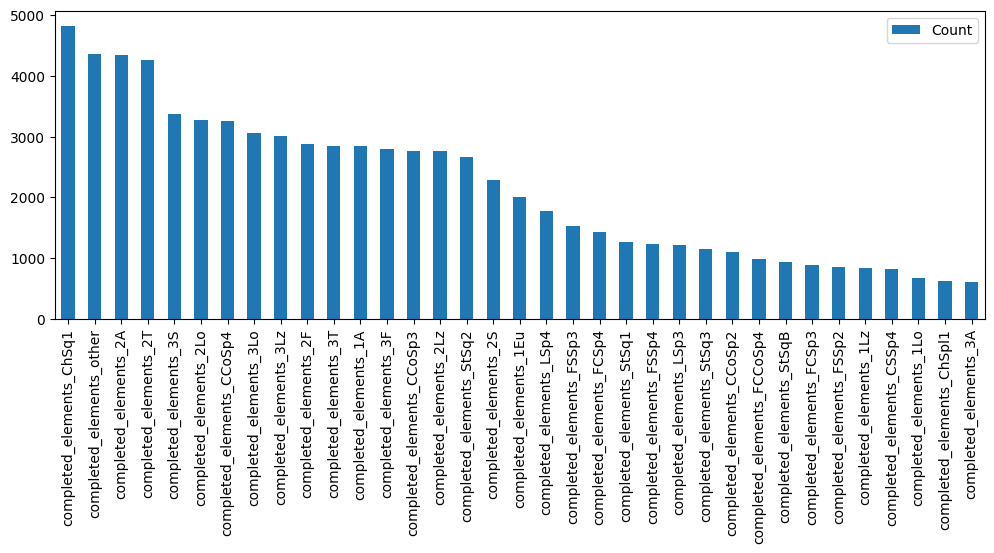

In [88]:
X_train, X_test, y_train, y_test = prepare_data(data=df, shifts = 1, learn = ['err','correct','completed', 'type_error'], target = ['completed'], test_count = 1)
pd.DataFrame(y_train.sum()).rename(columns = {0:'Count'}).sort_values(by = 'Count', ascending = False).plot.bar(figsize = (12,4))

Мы наблюдаем сильный дисбаланс классов. После того, как мы объединили финальный датасет, некоторые элементы снова оказались выполнены меньше 1000 раз, поскольку они повторялись внутри одного турнира. Нам нужно решить проблему дибаланса классов. Напишем специальную функцию.

In [89]:
def smart_upsampling(X,y): # Данные, которые мы будем семплировать (в данном случае, только тренировочные данные)
    r_classes = list(y.columns) # Список всех колонок target
    classes = list(pd.DataFrame(y.sum()).rename(columns = {0:'sum'}).sort_values(by = 'sum',ascending = True).reset_index()['index']) #Список колонок таргета с количеством элементов
    train_classes = list(X.columns) # Список колонок с признаками
    max_value = y.sum().max() # Максимальное количество элементов
    train = pd.concat([X, y], axis = 1) # Временно объединяем датасет
    train_ret = train.copy() # Копируем датасет

    for i in classes: #Проходимся во всем колонкам таргета
        
        c_value = train_ret[i].sum() # Смотрим конкретное количества элементов в обучающей выборке
  
        if c_value != 0: # Проверяем не ноль ли их, чтобы избежать ошибки деления на ноль
            m_value = round(max_value / c_value) # Теперь нам нужно определить, на какое число умножать наш элемент. Число равно округлённому делению максимального количества элементов на количество конкретного элемента
            # Грубо говоря, если наш элемент встречается в два раза реже, чем максимальный, то умножаем на два.
           
            if m_value > 1: # Проверяем, надо ли нам умножать
                q_string = f"{i} == 1" 
                tmp = train.query(q_string).copy() # Выделяем строки, которые будем копировать, то есть где наш класс равен единицы
                tmp2 = tmp.copy()
                
                for i2 in range(m_value - 1): # Копируем наши строки (мы учитываем, что в данных уже есть один набор строк)
                    tmp2 = pd.concat([tmp2, tmp], axis = 0)

                train_ret = pd.concat([tmp2, train_ret], axis = 0) # Добавляем в данные наши строки
                
    return train_ret[train_classes], train_ret[r_classes]

Проверим нашу функцию

In [90]:
X_train, y_train = smart_upsampling(X_train, y_train )

<Axes: >

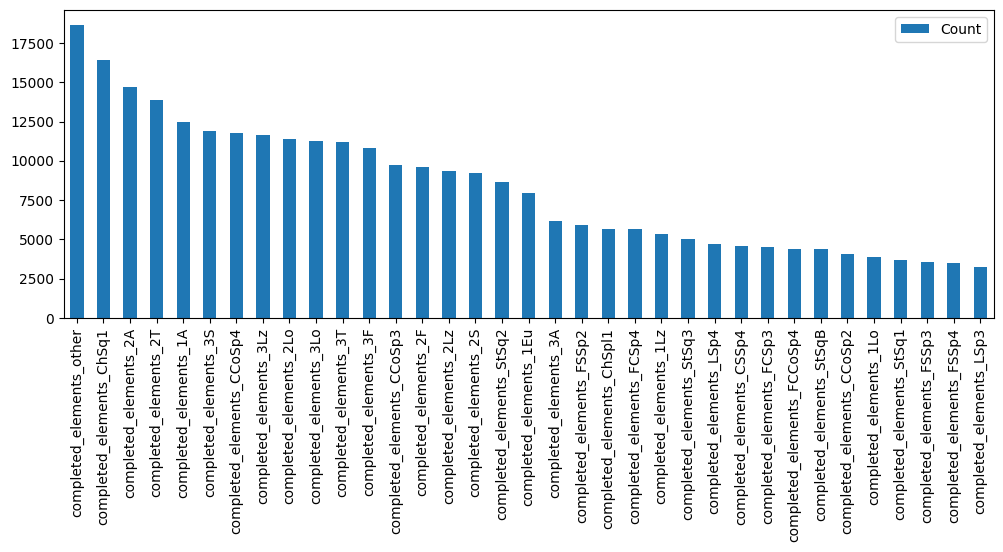

In [91]:
pd.DataFrame(y_train.sum()).rename(columns = {0:'Count'}).sort_values(by = 'Count', ascending = False).plot.bar(figsize = (12,4))

В целом, дисбаланс остаётся, поскольку в одной строке может быть много элементов, и редкие элементы, то есть те, которые мы хотим скопировать, могут встретиться вместе с частыми, которые нам копировать не нужно. Таким образом, частые элементы также будут копироваться. Тем не менее, такой метод позволил улучшить метрики, причём в большей степени, чем простое дублирование датасета, потому мы всё же будем его использовать.

### Получение метрик

Нам нужно получить метрики для наших моделей. Мы будем смотреть среднее для точности, f1 и так далее. Напишем вспомогательные функции

In [92]:
# Функция, для вычисление точности
def multilabel_accuracy(true,predicted):
    predicted = pd.DataFrame(data = predicted, columns =list(true.columns) )
    acc = []
    for i in list(predicted.columns): # Проходимся по каждому предсказанному значению и определяем метрику для него
        acc.append(accuracy_score(predicted[i], true[i]))
    return acc # Возвращаем список все предсказанных точностей


# Остальные функции действуют по аналогии с первой
def multilabel_f1(true,predicted):
    predicted = pd.DataFrame(data = predicted, columns =list(true.columns) )
    f1 = []
    for i in list(predicted.columns):
        f1.append(f1_score(predicted[i], true[i], zero_division = 1))
    return f1

def multilabel_precision_score(true,predicted):
    predicted = pd.DataFrame(data = predicted, columns =list(true.columns) )
    precision = []
    for i in list(predicted.columns):
        precision.append(precision_score(predicted[i], true[i], zero_division = 1))
    return precision

def multilabel_recall_score(true,predicted):
    predicted = pd.DataFrame(data = predicted, columns =list(true.columns) )
    recall = []
    for i in list(predicted.columns):
        recall.append(recall_score(predicted[i], true[i], zero_division = 1))
    return recall



Теперь напишем функцию, которая будет выдавать нам полноценный отчёт. Ниже мы составим список наших моделей и сравним их метрики для предсказания разных вещей. Потому функция будет возвращать список, также по желанию она сможет показать метрики для каждого элемента, а не только средние.

In [93]:
def score_report(
        true, # Истинные данные
        pred, # Предсказанные значения (порядок важен!)
        print_metrics=False,  # Печатать ли значения после получения отчёта?
        display_metrics = False, # Показывать ли подробный отчёт (по каждому классу) ?
        return_metrics = True,  # Возвращать ли метрики?
        model_name = 'default' # Название модели (нужно для составления списка)
        ):
    

    # Получаем наши метрики, используя функции, написанные выше
    accuracy = multilabel_accuracy(true, pred)
    f1 = multilabel_f1(true, pred)
    precision = multilabel_precision_score(true,pred)
    recall = multilabel_recall_score(true,pred)
    roc_auc = [-1] * len(recall)
    try:
        roc_auc = roc_auc_score(true,pred,average=None)
    except:
        pass
    
    # Делаем список из признаков а также всех метрик для подробного отчёта
    lists = [list(true.columns), f1, accuracy,precision, recall, roc_auc]

    # Превращаем подробный отчёт в небольшой датафрейм чтобы удобней было смотреть
    report  = pd.concat([pd.Series(x) for x in lists], axis=1)
    report = report.rename(columns = {0:'element', 1:'f1', 2:'acc',3:'precision',4:'recall', 5:'roc-auc'})

    # Печатаем метрики
    if print_metrics:
        print(f"f1 : {report['f1'].mean():.2f}, accuracy : {report['acc'].mean():.2f}, precision : {report['precision'].mean():.2f}, recall : {report['recall'].mean():.2f}, roc-auc: {report['roc-auc'].mean():.2f}")
    
    # Выводим подробный отчёт
    report = report.round(2)
    if display_metrics:
        display(report)
    
    # Возвращаем список метрик
    r_m = [model_name, report['f1'].mean(), report['acc'].mean(), report['precision'].mean(), report['recall'].mean(), report['roc-auc'].mean()]
    if return_metrics:
        return r_m

Теперь напишем функцию, которая выведет итоговую таблицу с метриками для разных моделей. Она будут принимать список и преобразовывать его в датафрейм, смотря на который мы сможем сравнить наши модели

In [94]:
def make_report(report):
    
    return pd.DataFrame(report).rename(columns = {0:'Model', 1:'f1', 2:'acc', 3:'precision', 4:'recall', 5:'roc-auc'}).round(2).sort_values(by = 'f1', ascending = True)

### Обучение и тестирование моделей

Для начала нам нужно обучить dummy-модели, чтобы проверить на адекватность настоящие модели. Для этого напишем отдельную функцию

In [95]:

def dummy_test(X_train, X_test, y_train, y_test): # Данные

    report = [] # Список для отчёта
    for i in ['most_frequent', 'prior', 'stratified', 'uniform', 'constant_1', 'constant_0']: # Все виды "стратегий", которые мы будем применять для кукольной модели
        
        #О бучаем кукольные модели
        if i not in ['constant_1', 'constant_0']:
            dummy_clf = DummyClassifier(strategy = i, random_state = 42)
            dummy_clf.fit(X_train, y_train)
        elif i == 'constant_1':
            dummy_clf = DummyClassifier(strategy = 'constant', constant= [1] * len(y_train.columns))
            dummy_clf.fit(X_train, y_train)
        else:
            dummy_clf = DummyClassifier(strategy = 'constant', constant= [0] * len(y_train.columns))
            dummy_clf.fit(X_train, y_train)
        p = dummy_clf.predict(X_test)
        # Добавляем метрики в отчёт
        report.append(score_report(y_test,p,print_metrics=False, model_name=f'Dummy ({i})') )

    return report 


Теперь обучим несколько моделей в каждой категори и посмотрим, какая из них в результате справится лучше. Инициализируем списки

In [96]:
total_report = {'err':[],'correct':[],'completed':[], 'type_error':[]}

In [97]:
targets = ['err','correct','completed', 'type_error']
for i in tqdm(range(len(targets))):

    _report = []
    # Готовим данные
    X_train, X_test, y_train, y_test = prepare_data( target = [targets[i]] )
    
    
    X_train, y_train = smart_upsampling(X_train,y_train)
    
    print('Dummy')

    # Обучаем кукольную модель
    _report += dummy_test(X_train, X_test, y_train, y_test)
    
    print('CatBoost')
    # Обучаем CatBoost
    clf = CatBoostClassifier(
    loss_function='MultiCrossEntropy',
    iterations=1000,
    depth = 4,
    random_state = 42
    )
    
    clf.fit(X_train, y_train,  plot=False, verbose=100)

    y_pred = clf.predict(X_test)
    _report += [score_report(y_test, y_pred, model_name = 'CatBosst')]
    
    print('XGBClassifier')
    # Обучаем XGBClassifier
    model = xgb.XGBClassifier( random_state = 42, verbosity = 0)
    model.fit(X_train.to_numpy(), y_train.to_numpy())

    y_pred = model.predict(X_test.to_numpy())
    _report += [score_report(y_test, y_pred, model_name = 'XGBClassifier')]
    
    # Записываем всё в свловарь
    total_report[targets[i]] = _report



  0%|          | 0/4 [00:00<?, ?it/s]

Dummy
CatBoost
Learning rate set to 0.03293
0:	learn: 0.6410848	total: 264ms	remaining: 4m 23s
100:	learn: 0.1619301	total: 12.1s	remaining: 1m 47s
200:	learn: 0.1282098	total: 24.3s	remaining: 1m 36s
300:	learn: 0.1098355	total: 36.4s	remaining: 1m 24s
400:	learn: 0.0978266	total: 48.4s	remaining: 1m 12s
500:	learn: 0.0895520	total: 1m	remaining: 1m
600:	learn: 0.0833694	total: 1m 12s	remaining: 47.8s
700:	learn: 0.0786920	total: 1m 24s	remaining: 35.8s
800:	learn: 0.0748051	total: 1m 35s	remaining: 23.8s
900:	learn: 0.0715623	total: 1m 47s	remaining: 11.8s
999:	learn: 0.0689661	total: 2m	remaining: 0us
XGBClassifier
Dummy
CatBoost
Learning rate set to 0.038213
0:	learn: 0.6500852	total: 197ms	remaining: 3m 16s
100:	learn: 0.2823979	total: 21.6s	remaining: 3m 12s
200:	learn: 0.2529177	total: 43.2s	remaining: 2m 51s
300:	learn: 0.2339690	total: 1m 4s	remaining: 2m 29s
400:	learn: 0.2195411	total: 1m 25s	remaining: 2m 7s
500:	learn: 0.2075944	total: 1m 45s	remaining: 1m 45s
600:	learn: 

Попробуем предсказать элементы, выполненные с ошибками.

In [98]:
make_report(total_report['err'])

,Model,f1,acc,precision,recall,roc-auc
0,Dummy (most_frequent),0.00,0.91,0.00,1.00,0.50
1,Dummy (prior),0.00,0.91,0.00,1.00,0.50
5,Dummy (constant_0),0.00,0.91,0.00,1.00,0.50
4,Dummy (constant_1),0.16,0.09,1.00,0.09,0.50
3,Dummy (uniform),0.18,0.50,0.51,0.09,0.51
2,Dummy (stratified),0.34,0.82,0.11,0.09,0.49
6,CatBosst,0.35,0.93,0.22,0.66,0.60
7,XGBClassifier,0.41,0.93,0.25,0.57,0.61


Мы можем заметить, что модели в целом плохо справляются с этим предсказанием. Притом CatBoost справился хуже даже кукольной модели, но XGBClassifier справился лучше.

Теперь посмотрим как модели справились с предсказанием правильно выполненных элементов.

In [99]:
make_report(total_report['correct'])

,Model,f1,acc,precision,recall,roc-auc
5,Dummy (constant_0),0.00,0.73,0.00,1.00,0.5
0,Dummy (most_frequent),0.05,0.76,0.06,0.98,0.5
1,Dummy (prior),0.05,0.76,0.06,0.98,0.5
2,Dummy (stratified),0.27,0.64,0.29,0.27,0.5
3,Dummy (uniform),0.32,0.50,0.50,0.27,0.5
4,Dummy (constant_1),0.40,0.27,1.00,0.27,0.5
6,CatBosst,0.69,0.88,0.67,0.74,0.8
7,XGBClassifier,0.70,0.88,0.68,0.73,0.8


Обе модели - CatBosst и XGBClassifier справились лучше кукольных моделей. При этом, мы имеем довольно неплохие результаты.

Теперь посмотрим на предсказание того, будет ли спортсмен в принципе выполнять тот или иной элемент.

In [100]:
make_report(total_report['completed'])

,Model,f1,acc,precision,recall,roc-auc
5,Dummy (constant_0),0.00,0.70,0.00,1.00,0.50
0,Dummy (most_frequent),0.09,0.73,0.11,0.96,0.50
1,Dummy (prior),0.09,0.73,0.11,0.96,0.50
2,Dummy (stratified),0.30,0.63,0.32,0.30,0.50
3,Dummy (uniform),0.35,0.50,0.50,0.30,0.50
4,Dummy (constant_1),0.44,0.30,1.00,0.30,0.50
6,CatBosst,0.72,0.88,0.70,0.77,0.81
7,XGBClassifier,0.72,0.89,0.70,0.76,0.81


Теперь посмотрим на предсказания того, какого типа ошибки допустит спортсмен.

In [101]:
make_report(total_report['type_error'])

,Model,f1,acc,precision,recall,roc-auc
5,Dummy (constant_0),0.00,0.86,0.00,1.00,0.50
0,Dummy (most_frequent),0.08,0.91,0.10,0.98,0.50
1,Dummy (prior),0.08,0.91,0.10,0.98,0.50
4,Dummy (constant_1),0.19,0.14,1.00,0.14,0.50
3,Dummy (uniform),0.20,0.50,0.49,0.14,0.49
6,CatBosst,0.28,0.92,0.16,0.66,0.53
2,Dummy (stratified),0.39,0.81,0.21,0.14,0.50
7,XGBClassifier,0.39,0.92,0.17,0.52,0.54


Как мы видим, наша модель справилась не намного лучше кукольной, предсказать это очень сложно.

## Вывод

Мы сумели выделить основные элементы фигурного катания и саггрегировать финальный датасет. 

Мы сумелм разделить датасет на обучающую и тестовую выборку. Мы предсказывали следующие вещи: какие элементы за весь турнир спорсмен хоть раз выполнит без ошибки, в каких элементах за весь турнир спорсмен хоть раз ошибётся, какие элементы в принципе спортсмен выполнит за турнир и какие конкретно ошибки допустит спортсмен. 

В качестве признаков брались результаты и элементы предыдущих турниров, в которых участвовал спортсмен, в этом плане задача внешне походит на временные ряды. 

Помимо обучения модели, мы провели "проверку на адекватность", используя кукольные модели (то есть такие, которые ставят случайный результат и так далее). 

Лучше всего модели способны предсказать элементы, которые в принципе выполнялись спортсменом (вне зависимости от результата), затем - корректно исполненные элементы. Очень плохо, но всё же лучше кукольных моделей, удалось предсказать какие элементы спортсмен выполнит с ошибкой, и вообще не удалось предсказать сами ошибки (лучший результат не отличается от кукольной модели).

Лучшей моделью оказался XGBClassifier.

Общий вывод, который можно сделать заключается в том, что в принципе задача решаемая, и при большем объёме данных (включающих в себя и те признаки, которые не попали в датасет, например физические характеристики спорсменов и так далее) можно добиться более или менее полезных результатов.

